In [44]:
import json
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

from utils.ltt_utils import create_x_y, run_ltt_cv, run_naive_precision_contorl

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
ANNOTATIONS_PATH = "/home/innerve/final_repo_miccai/follicle-assessment/data/01_ovary_cuts/ovaries_annotations.json"
PREDICTIONS_PATH = "/home/innerve/final_repo_miccai/follicle-assessment/data/04_model_predictions/efficientdet/results.json"
IOU_TH = .3
TARGET_PRECISION = 0.3
THS_DEPTH = np.arange(.3, .8, .05)
THS_OBJ = np.arange(.45, .8, .01)
DELTA = 0.001

In [27]:
with open(ANNOTATIONS_PATH, "r") as f:
    annotations = json.load(f)

with open(PREDICTIONS_PATH, "r") as f:
    predictions = json.load(f)


In [21]:
ltt_results_depth = run_ltt_cv(annotations, predictions, target_precision=TARGET_PRECISION, iou_th=IOU_TH, ths_obj=THS_OBJ, ths_depth=THS_DEPTH, classes="all", with_depth=True, delta=DELTA)

ltt_results_classical = run_ltt_cv(annotations, predictions, target_precision=TARGET_PRECISION, iou_th=IOU_TH, ths_obj=THS_OBJ, ths_depth=THS_DEPTH, classes="all", with_depth=False, delta=DELTA)

naive_method = run_naive_precision_contorl(annotations, predictions, target_precision=TARGET_PRECISION, iou_th=IOU_TH, ths_obj=THS_OBJ, classes="all")

  0%|          | 0/20 [00:00<?, ?it/s]/home/innerve/micromamba/envs/folcon/lib/python3.8/site-packages/mapie/control_risk/p_values.py:117: RuntimeWarning: divide by zero encountered in log
  elt1 = r_hats * np.log(r_hats/alphas)
/home/innerve/micromamba/envs/folcon/lib/python3.8/site-packages/mapie/control_risk/p_values.py:117: RuntimeWarning: invalid value encountered in multiply
  elt1 = r_hats * np.log(r_hats/alphas)
100%|██████████| 20/20 [00:01<00:00, 17.25it/s]


In [94]:
def get_p_r_ltt(annotations, predictions, ltt_results, name):
    global_precisions = []
    global_recalls = []
    global_f1s = []
    for sld_name in ltt_results.keys():
        if len(ltt_results[sld_name]["best_th_depth"]) == 0:
            th_depth = 1
        else:
            th_depth = ltt_results[sld_name]["best_th_depth"][0]
        th_obj = ltt_results[sld_name]["best_th_obj"]
        X, y = create_x_y([sld_name], annotations, predictions, iou_th=IOU_TH, classes="all", with_depth=True)

        X[X[:, :, 1] > th_depth] = 0
        X = X[:, :, 0]
        X_th = X >= th_obj
        precisions = [precision_score(y[i], X_th[i], zero_division=1) for i in range(len(y))]
        recalls = [recall_score(y[i], X_th[i], zero_division=1) for i in range(len(y))]
        f1s = [f1_score(y[i], X_th[i]) for i in range(len(y))]

        global_precisions.append(np.mean(precisions))
        global_recalls.append(np.mean(recalls))
        global_f1s.append(np.mean(f1s))
    
    final_dico = {
        "Metric": ["precisions"] * len(global_precisions) + ["recalls"] * len(global_recalls) + ["f1s"] * len(global_f1s),
        "Value": global_precisions + global_recalls + global_f1s,
        "Method": [name] * (len(global_precisions) + len(global_recalls) + len(global_f1s))
    }

    return final_dico

In [95]:
dico_ltt_detph = get_p_r_ltt(annotations, predictions, ltt_results_depth, "LTT with depth")
dico_ltt_classical = get_p_r_ltt(annotations, predictions, ltt_results_classical, "LTT classical")
ltt_results_naive = get_p_r_ltt(annotations, predictions, naive_method, "Naive method")

In [96]:
concat_dico = pd.concat([pd.DataFrame(dico_ltt_detph), pd.DataFrame(dico_ltt_classical), pd.DataFrame(ltt_results_naive)])

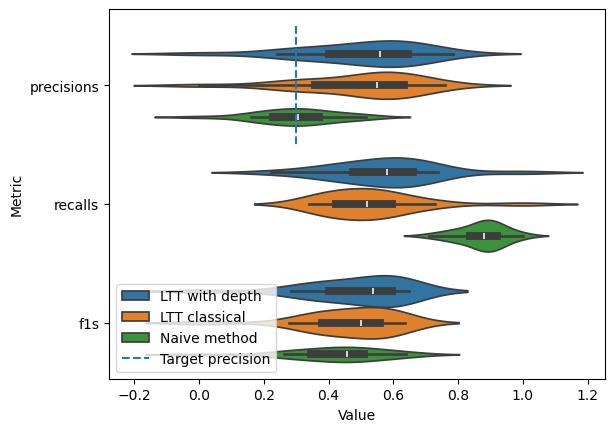

In [97]:
sns.violinplot(data=concat_dico,  x="Value", y="Metric", hue="Method", split=False, orient="h")
plt.vlines(TARGET_PRECISION, -0.5, .5, linestyles="dashed", label="Target precision")
plt.legend()
